In [65]:
# Standard DS imports
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import ast
from sklearn import svm
import time

# All pytorch dependencies
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split



# all tensorflow dependencies
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping
from keras import metrics

In [66]:
# Global var for selecting popularity cutoff
MINIMUM_POPULARITY_LIMIT = 40
MINIMUM_POPULARITY_PERCENTAGE = MINIMUM_POPULARITY_LIMIT / 100

In [69]:
def analyze_algorithm(y_true, y_pred):

    # Calculate all scoring metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    precision = precision_score(y_true, y_pred, average='macro')
    
    recall = recall_score(y_true, y_pred, average='macro')
    
    f1 = f1_score(y_true, y_pred, average='macro')

    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall_auc, precision_auc)
    
    cm = confusion_matrix(y_true, y_pred)



    print(f"Accuracy: {round(accuracy, 6)}")

    print(f"Recall: {round(recall, 6)}")

    print(f"Precision: {round(precision, 6)}")

    print(f"F1 Score: {round(f1, 6)}")

    print(f"AUPRC: {round(auprc, 6)}")

    # Visualize the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    



def print_correlation_matrix(dataframe):
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True,)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()





def predict_and_convert(model, x_data, y_data, cutoff):

    y_scores = model.predict(x_data)
    y_pred = (y_scores > cutoff).astype(int)
    y_data = (y_data > cutoff).astype(int)
    return y_data, y_pred





def find_best_kernel_value(is_classifier, x_train, y_train, x_test, y_test):
    k_values = range(1,6,1)
    train_scores = []
    test_scores = []
    scores_dict = {}

    for k in tqdm(k_values):
        model = neighbors.KNeighborsClassifier(k) if is_classifier else neighbors.KNeighborsRegressor(k)
        model.fit(x_train, y_train.values.ravel())

        y_train_predicted = model.predict(x_train)
        y_test_predicted = model.predict(x_test)

        if is_classifier:
            train_scores.append(f1_score(y_train, y_train_predicted, average='macro'))
            test_score = f1_score(y_test, y_test_predicted, average='macro')
        else:
            y_train_binary = (y_train >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_train_predicted_binary = (y_train_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_binary = (y_test >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_predicted_binary = (y_test_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)
            
            # Then, compute the accuracy
            train_scores.append(f1_score(y_train_binary, y_train_predicted_binary, average='macro'))
            test_score = f1_score(y_test_binary, y_test_predicted_binary, average='macro')

        test_scores.append(test_score)
        scores_dict[k] = test_score

    plt.plot(k_values, train_scores, 'r-s', label='Train')
    plt.plot(k_values, test_scores, 'b-o', label='Test')
    plt.legend()
    plt.show()

    best_k = max(scores_dict, key=scores_dict.get)
    print(f"The best k value is : {best_k} with score: {scores_dict[best_k]}")

    return best_k

tracks.csv read in successfully as a dataframe


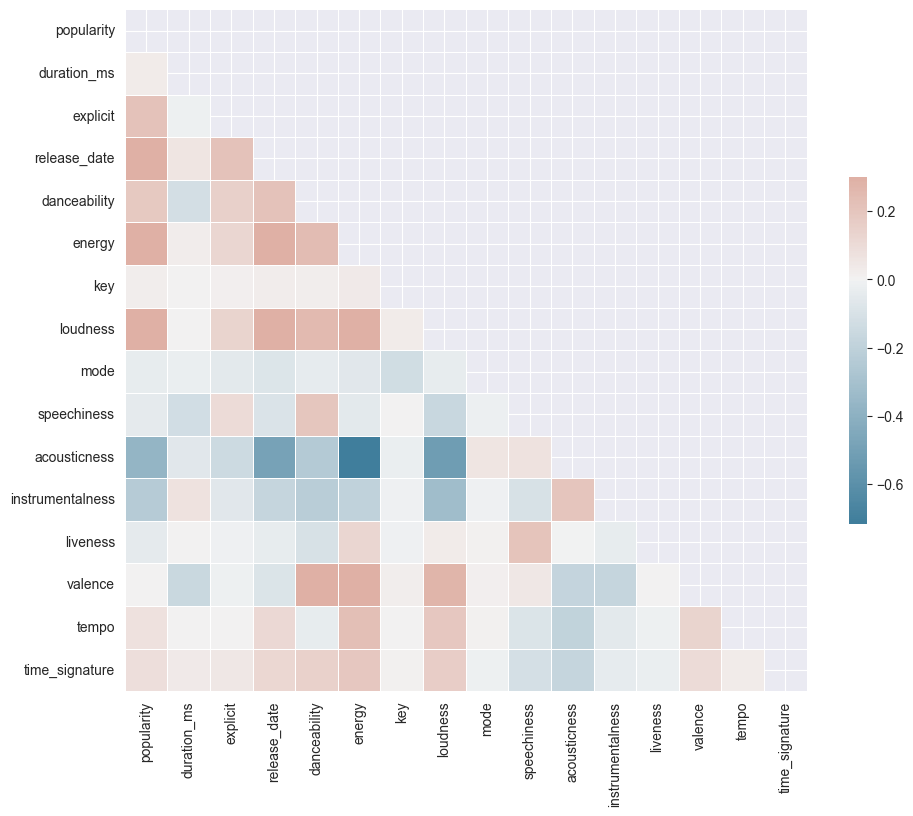

100%|██████████| 5/5 [00:58<00:00, 11.80s/it]


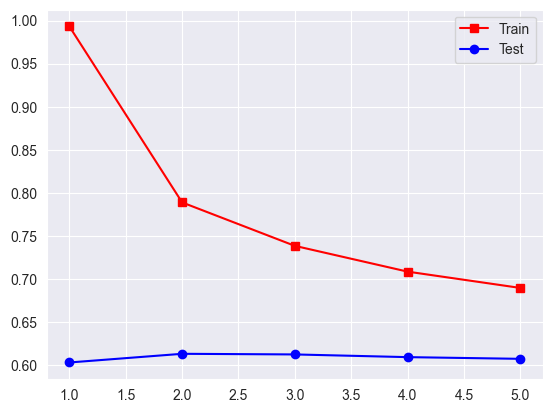

The best k value is : 2 with score: 0.6132694206269218
KNN-Regressor Fitted

scores for the training set:
Accuracy: 0.849439
Recall: 0.773419
Precision: 0.809651
F1 Score: 0.788532
AUPRC: 0.728323


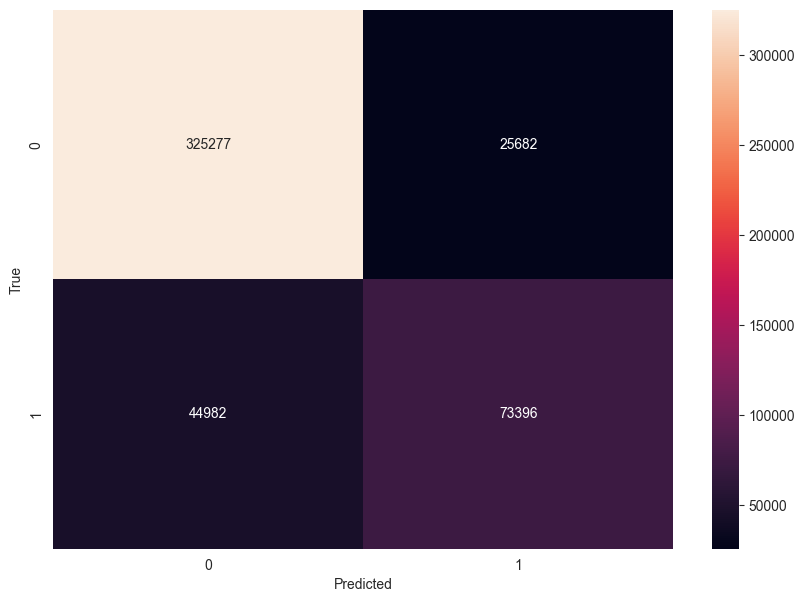


scores for the testing set:
Accuracy: 0.723612
Recall: 0.606557
Precision: 0.619185
F1 Score: 0.611343
AUPRC: 0.483369


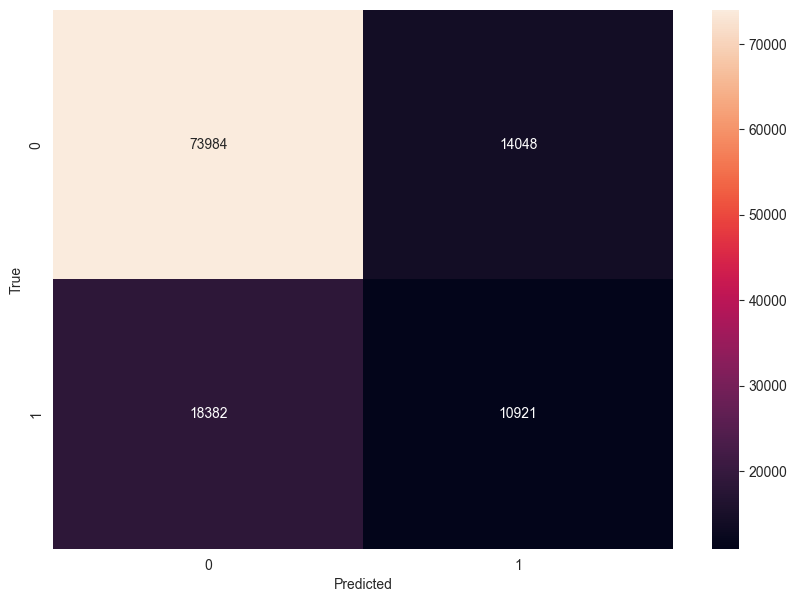

100%|██████████| 5/5 [01:23<00:00, 16.64s/it]


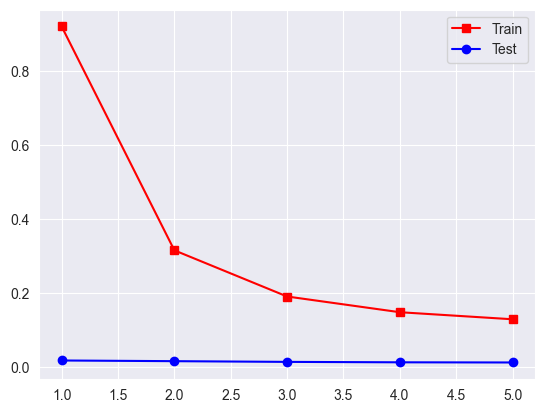

The best k value is : 1 with score: 0.017705664201476127
KNN-Classifier Fitted

scores for the training set:
Accuracy: 0.994526
Recall: 0.992796
Precision: 0.992694
F1 Score: 0.992745
AUPRC: 0.9905


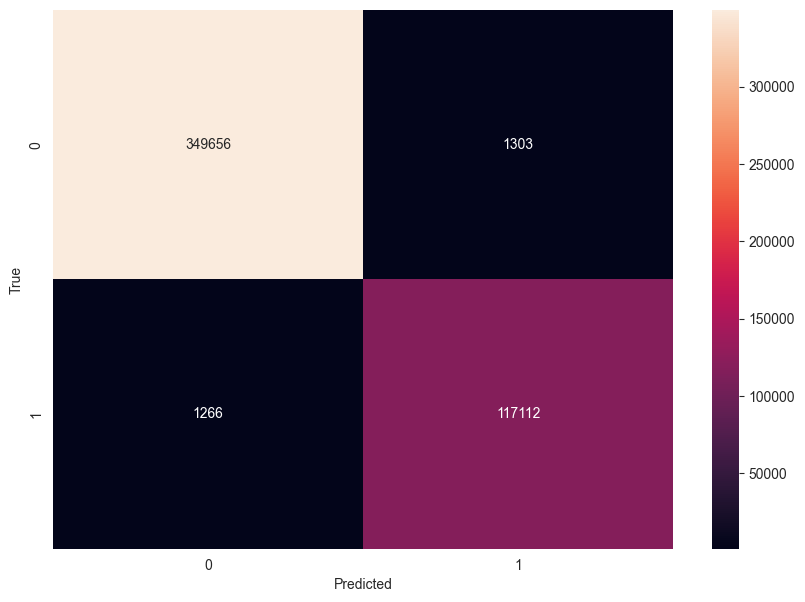


scores for the testing set:
Accuracy: 0.695982
Recall: 0.60359
Precision: 0.6
F1 Score: 0.601613
AUPRC: 0.480562


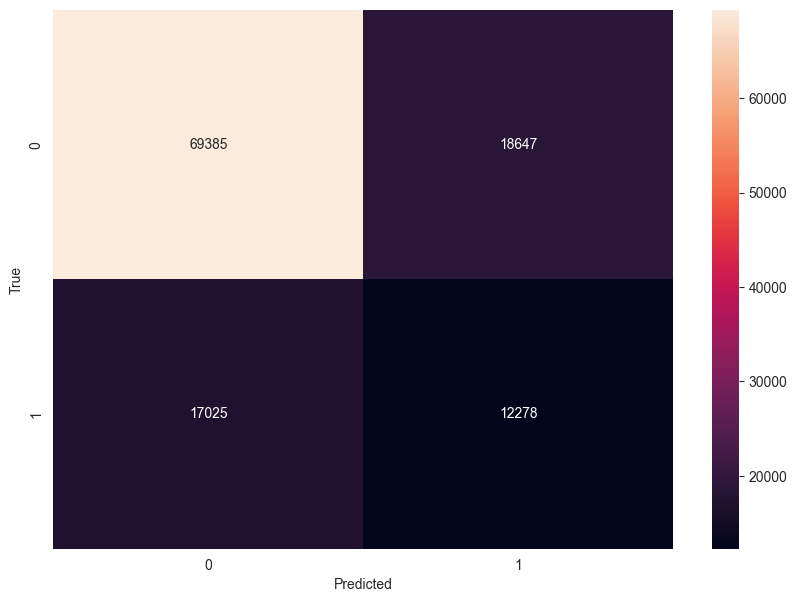

In [ ]:
# Putting file specific info into arrays for easier access
files = ['tracks.csv', 'dataset.csv']
inputs = [
            [ 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit'],
                  
            ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
        ]
target = ['popularity']

model_scores = {}  # Save F1 Scores for each model

start_time = time.time()


for i in range(len(files)):

    df = pd.read_csv('./'+files[i])
    print(files[i], 'read in successfully as a dataframe')
    # File specific cleaning
    
    # Data cleaning for tracks.csv
    if i == 0:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
        df = df.drop(columns=['id', 'name', 'artists', 'id_artists'])
        
    # Data cleaning for dataset.csv
    if i == 1:
        df['track_genre_encoded'] = LabelEncoder().fit_transform(df['track_genre'])
        df = df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])
        
       
    print_correlation_matrix(df)

    xtrain, xtest, ytrain, ytest = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)
    
    # Training Model 1 KNN-Regressor
    kernelNumber = find_best_kernel_value(False, xtrain, ytrain, xtest, ytest)

    modelOne = neighbors.KNeighborsRegressor(kernelNumber)
    modelOne.fit(xtrain, ytrain)
    print('KNN-Regressor Fitted')
    
    # Apply a same threshold to train predictions
    y_train, y_train_pred = predict_and_convert(modelOne, xtrain, ytrain, MINIMUM_POPULARITY_LIMIT)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred)
    
    y_test, y_test_pred = predict_and_convert(modelOne, xtest, ytest, MINIMUM_POPULARITY_LIMIT)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred)

    model_scores['knn_regressor'] = f1_score(y_test, y_test_pred)
    
    
    
    # Training Model 2 KNN-Classifier
    y_train_two = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
    y_test_two = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)
    
    kernelNumber = find_best_kernel_value(True, xtrain, y_train_two, xtest, y_test_two)

    modelTwo = neighbors.KNeighborsClassifier(kernelNumber)
    modelTwo.fit(xtrain, y_train_two.values.ravel())
    print('KNN-Classifier Fitted')

    y_train_pred = modelTwo.predict(xtrain)
    print('\nscores for the training set:')
    analyze_algorithm(y_train_two, y_train_pred)
    
    # Apply a same threshold to test predictions
    y_test_pred = modelTwo.predict(xtest)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test_two, y_test_pred)

    model_scores['knn_classifier'] = f1_score(y_test_two, y_test_pred)



    # Training Model 3 SVM
    sc = StandardScaler()
    X_train = sc.fit_transform(xtrain)
    X_test = sc.transform(xtest)
    
    # Training the SVM model on the Training set using a linear kernel
    svm_classifier = SVC(kernel = 'rbf', random_state = 42)
    svm_classifier.fit(X_train, ytrain.values.ravel())  
    print('SVM-Classifier Fitted')
    
    # Predicting the results
    print('\nscores for the training set:')
    y_pred = svm_classifier.predict(X_train)
    analyze_algorithm(ytrain, y_pred)
    
    print('\nscores for the testing set:')
    y_pred = svm_classifier.predict(X_test)
    analyze_algorithm(ytest, y_pred)

    model_scores['svm_classifier'] = f1_score(y_test, y_pred)
    
    

# End timing and print the result
end_time = time.time()

print("\nExecution time: {} seconds".format(end_time - start_time))
    